In [103]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix

In [104]:
df = pd.read_excel('oil_training_data.xlsx', sheet_name='tab_treinamento1')

for i in df.columns:
    df[i] = df[i]*0.0000001

In [105]:
df_test = pd.read_excel('oil_test_data.xlsx', sheet_name='tab_teste1')

for i in df_test.columns:
    df_test[i] = df_test[i]*0.0000001

df_test.head()

,x1,x2,x3
0,-0.3565,0.0620,5.9891
1,-0.7842,1.1267,5.5912
2,0.3012,0.5611,5.8234
3,0.7757,1.0648,8.0677
4,0.1570,0.8028,6.3040


In [106]:
df.loc[df['classe'] == -1, 'classe'] = 0
df['classe'] = df['classe'].astype(int)
print(df['classe'].value_counts())
df.head()

1    16
0    14
Name: classe, dtype: int64


,x1,x2,x3,classe
0,-0.6508,0.1097,4.0009,0
1,-1.4492,0.8896,4.4005,0
2,2.0850,0.6876,12.0710,0
3,0.2626,1.1476,7.7985,1
4,0.6418,1.0234,7.0427,1


In [107]:
X_train, X_test, y_train, y_test = train_test_split(df[['x1', 'x2', 'x3']], df[['classe']], test_size=0.32)

In [108]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((20, 3), (10, 3), (20, 1), (10, 1))

In [109]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

test_scaled = scaler.fit_transform(df_test)

In [110]:
print(df_test)

       x1      x2      x3
0 -0.3565  0.0620  5.9891
1 -0.7842  1.1267  5.5912
2  0.3012  0.5611  5.8234
3  0.7757  1.0648  8.0677
4  0.1570  0.8028  6.3040
5 -0.7014  1.0316  3.6005
6  0.3748  0.1536  6.1537
7 -0.6920  0.9404  4.4058
8 -1.3970  0.7141  4.9263
9 -1.8842 -0.2805  1.2548


In [111]:
model = LogisticRegression()
model.fit(X_train, y_train)

predict_convencional = model.predict(test_scaled)
print(predict_convencional)

[0 1 1 0 1 1 0 1 1 1]


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [112]:
model_RNA = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(3,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')
])
model_RNA.summary()

es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   patience=10,
                   restore_best_weights=True)

model_RNA.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'],)

epochs=50

history = model_RNA.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=32,
                        verbose=1)

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_70 (Dense)            (None, 128)               512       
                                                                 
 dense_71 (Dense)            (None, 64)                8256      
                                                                 
 dense_72 (Dense)            (None, 32)                2080      
                                                                 
 dense_73 (Dense)            (None, 1)                 33        
                                                                 
Total params: 10,881
Trainable params: 10,881
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
1/1 [==============================] - 1s 1s/step - loss: 6.6484 - accuracy: 0.3000
Epoch 2/50
1/1 [==============================] - 0s 14ms/step - loss: 4.3808 - accura

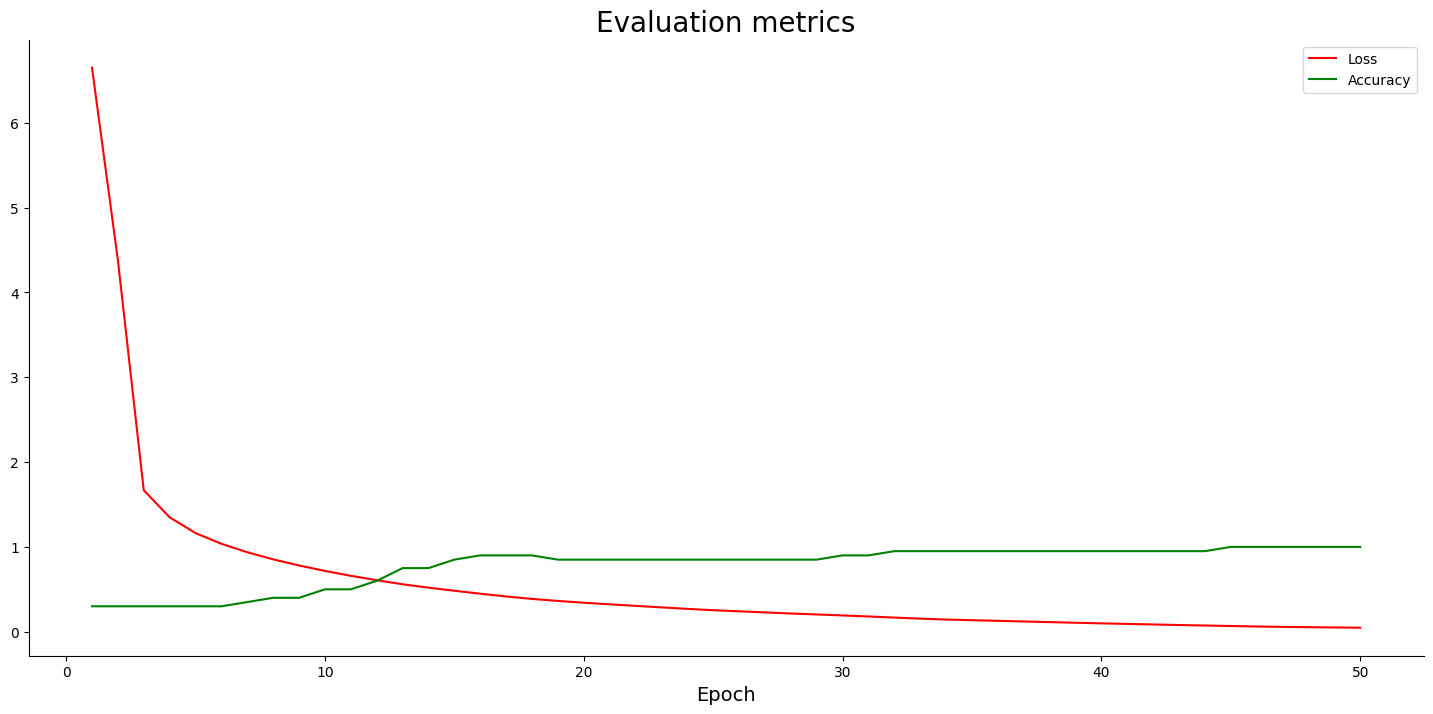

In [113]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['figure.figsize'] = (18, 8)
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False

plt.plot(np.arange(1, epochs + 1), history.history['loss'], color='red', label='Loss')
plt.plot(np.arange(1, epochs + 1), history.history['accuracy'], color='green', label='Accuracy')
plt.title('Evaluation metrics', size=20)
plt.xlabel('Epoch', size=14)
plt.legend();

In [114]:
RNA_predict = model_RNA.predict(test_scaled)

predict_class = [1 if prob > 0.5 else 0 for prob in np.ravel(RNA_predict)]
print(predict_class)

1/1 [==============================] - 0s 74ms/step
[0, 1, 1, 0, 0, 1, 0, 1, 1, 1]


In [115]:
arr_compare = predict_convencional == predict_class

In [116]:
np.unique(arr_compare, return_counts=True)

(array([False,  True]), array([1, 9]))

In [117]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, predict_class)

array([[4, 4],
       [0, 2]])

In [118]:
weights = model_RNA.layers[1].get_weights()[0]
biases = model_RNA.layers[1].get_weights()[1]

In [119]:
print(weights, biases)

[[-0.11125508 -0.13761047  0.01842587 ... -0.03132918  0.1326172
   0.09281661]
 [-0.08181886 -0.17935675  0.11694491 ... -0.14670347  0.12505403
   0.02311805]
 [ 0.144206    0.08683147  0.21351077 ...  0.11486471  0.13663165
  -0.03378593]
 ...
 [ 0.07055984  0.04201485  0.13792636 ... -0.00219942  0.11484464
  -0.01296141]
 [ 0.05243373  0.07220937  0.13704582 ... -0.06221643  0.14085199
  -0.02444274]
 [-0.06117889 -0.05272489 -0.13270219 ...  0.11039959  0.0512828
  -0.0896337 ]] [-0.01052766 -0.01487602 -0.00807847  0.03249658 -0.01130856  0.01877796
  0.01637821  0.01427754  0.02408347 -0.00738345  0.01040804  0.01135751
 -0.00857358  0.00184164  0.00815277 -0.00337651  0.03615468 -0.01186068
  0.01450147 -0.0077732  -0.01017693  0.01282151  0.01193925  0.01125405
 -0.00605706 -0.0063599  -0.00805981  0.02556445 -0.01096364  0.02041039
  0.01216911  0.01319983  0.01116776 -0.01326862 -0.00699825 -0.00589936
  0.00638798  0.01141676 -0.00618924 -0.00288049  0.01599684 -0.00646934